# Transfer Learning for AI Text Detection

Fine-tuning SOTA AI text detection models (`fakespot-ai/roberta-base-ai-text-detection-v1`) on the Mercor AI Detection dataset.

## Model Architecture

**Base Model**: `fakespot-ai/roberta-base-ai-text-detection-v1`
- RoBERTa-base architecture (768 hidden dimensions)
- Pretrained specifically for AI text detection tasks
- Provides strong initialization for our domain-specific fine-tuning

**Custom Classifier Head**: Replaces default classifier with a deeper ANN
- **Layer 1**: Linear(768 → 1024) + ReLU + Dropout(0.25)
- **Layer 2**: Linear(1024 → 512) + ReLU + Dropout(0.25)  
- **Output**: Linear(512 → 2) for binary classification
- Xavier uniform initialization for all layers
- Total parameters: ~1.3M in classifier head

## Input Features & Preprocessing

**Text Format**: Combines topic and answer into structured input
- Format: `"TOPIC: {topic}\n\nANSWER: {answer}"`
- Text cleaning: Removes extra whitespace, newlines, and normalizes spacing
- Tokenization: RoBERTa tokenizer with max_length=512, padding, and truncation
- Preserves context from both topic and answer for better detection

**Data Processing**:
- Upsamples minority class (label=0) to balance training set
- Stratified train/validation split (80/20) to maintain class distribution
- Converts to HuggingFace Dataset format for efficient batching

## Training Configuration

**Hyperparameters**:
- Learning rate: 2e-5 (standard for transformer fine-tuning)
- Batch size: 16 per device
- Max epochs: 10
- Weight decay: 0.01 (L2 regularization)
- Gradient accumulation: 1 step

**Training Strategy**:
- Early stopping with patience=2 (monitors validation ROC-AUC)
- Best model checkpointing based on validation ROC-AUC
- Saves top 3 checkpoints to prevent overfitting
- Mixed precision training disabled (FP16=False) for stability

**Optimization**:
- AdamW optimizer with weight decay
- Learning rate scheduling via Trainer's default scheduler
- Gradient clipping handled by accelerate library

## Evaluation & Metrics

**Primary Metric**: ROC-AUC (Area Under the ROC Curve)
- Best suited for imbalanced classification tasks
- Used for model selection and early stopping

**Additional Metrics**:
- Accuracy, Precision, Recall, F1-score
- ROC curves and Precision-Recall curves
- Confusion matrices for detailed error analysis

**Benchmarking**:
- Evaluates on HC3 dataset (Human ChatGPT Comparison Corpus)
- Uses 0.5% sample for fast benchmarking while maintaining statistical validity
- Compares performance against standard AI text detection benchmarks


In [49]:
!pip install --upgrade accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# Imports
import os
import sys
import random
import math
import warnings
import time
from collections import Counter

# Add parent directory to path for imports (since notebooks are in notebooks/ folder)
# This allows importing data_processing module from the parent directory
if os.path.basename(os.getcwd()) == 'notebooks':
    sys.path.insert(0, '..')
else:
    # If running from parent directory, add current directory
    sys.path.insert(0, '.')

# CRITICAL: Set environment variables BEFORE any other imports
# This prevents transformers from trying to import TensorFlow/Keras
os.environ['TRANSFORMERS_NO_TF'] = '1'
os.environ['TRANSFORMERS_NO_TF_IMPORT'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings
# Prevent TensorFlow from being imported at all
sys.modules['tensorflow'] = None
sys.modules['tf_keras'] = None

print("Loading standard libraries...")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, auc, precision_recall_curve
)

print("Loading PyTorch...")
import torch
import torch.nn as nn
import torch.nn.functional as F

# Import transformers with progress indicator and timeout protection
print("Loading transformers library (this may take 10-30 seconds)...")
print("  (If this hangs, you may need to uninstall tf_keras: !pip uninstall -y tf_keras)")

try:
    # Import with explicit error handling
    import importlib
    import importlib.util
    
    # Try to import transformers with a progress indicator
    start_time = time.time()
    from transformers import (
        AutoTokenizer,
        AutoConfig,
        AutoModelForSequenceClassification,
        DataCollatorWithPadding,
        TrainingArguments,
        Trainer,
        EarlyStoppingCallback,
        logging as transformers_logging
    )
    elapsed = time.time() - start_time
    print(f"  ✓ transformers loaded in {elapsed:.1f} seconds")
    
except ImportError as e:
    if "tf_keras" in str(e) or "Keras 3" in str(e) or "tensorflow" in str(e).lower():
        print("\n" + "=" * 60)
        print("ERROR: TensorFlow/Keras compatibility issue detected!")
        print("=" * 60)
        print("\nSOLUTION: Run the following command in a new cell:")
        print("  !pip uninstall -y tf_keras")
        print("\nThen RESTART THE KERNEL and run all cells again.")
        raise
    else:
        raise
except RuntimeError as e:
    if "tf_keras" in str(e) or "Keras 3" in str(e):
        print("\n" + "=" * 60)
        print("ERROR: tf_keras compatibility issue detected!")
        print("=" * 60)
        print("\nSOLUTION: Run the following command in a new cell:")
        print("  !pip uninstall -y tf_keras")
        print("\nThen RESTART THE KERNEL and run all cells again.")
        raise
    else:
        raise
except Exception as e:
    print(f"\nUnexpected error importing transformers: {e}")
    print("Try: !pip uninstall -y tf_keras")
    raise

print("Loading datasets library...")
from datasets import Dataset
print("✓ All imports successful")

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Settings
SEED = 42
MODEL_NAME = "fakespot-ai/roberta-base-ai-text-detection-v1"
MAX_LEN = 512
PER_DEVICE_TRAIN_BATCH = 16  # Reduced for local training
PER_DEVICE_EVAL_BATCH = 16
GRADIENT_ACCUMULATION_STEPS = 1
NUM_EPOCHS = 10
LEARNING_RATE = 2e-5
FP16 = False  # Set to True if using CUDA
OUTPUT_DIR = "./finetuned_roberta_ann_topic_answer"
PLOT_DIR = "./plots"

# Create directories
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

transformers_logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=UserWarning)

print("✓ Imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if hasattr(torch.backends, 'mps'):
    print(f"MPS available: {torch.backends.mps.is_available()}")


Loading standard libraries...
Loading PyTorch...
Loading transformers library (this may take 10-30 seconds)...
  (If this hangs, you may need to uninstall tf_keras: !pip uninstall -y tf_keras)
  ✓ transformers loaded in 0.0 seconds
Loading datasets library...
✓ All imports successful
✓ Imports successful
PyTorch version: 2.5.1
CUDA available: False
MPS available: True


## Helper Functions

In [27]:
# Helper functions
def clean_text_field(s):
    """Clean text field by removing extra whitespace and newlines."""
    if pd.isna(s):
        return ""
    return " ".join(str(s).strip().replace("\r", " ").replace("\n", " ").split())


def make_input_string(topic, answer):
    """Combine topic and answer into a formatted input string."""
    t = clean_text_field(topic)
    a = clean_text_field(answer)
    return f"TOPIC: {t}\n\nANSWER: {a}"


print("✓ Helper functions defined")


✓ Helper functions defined


## Load and Prepare Data
to 

In [ ]:
# Load data (from parent directory since notebooks are in notebooks/ folder)
df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Train shape: {df.shape}")
print(f"Test shape: {test_df.shape}")

# Validate required columns
required = {"topic", "answer", "is_cheating"}
if not required.issubset(df.columns):
    raise ValueError(f"train.csv must contain columns: {required}")

if "id" not in test_df.columns:
    raise ValueError("test.csv must contain column 'id'")

# Build combined text field
print("\nCreating combined text field (TOPIC + ANSWER)...")
df["text"] = df.apply(lambda r: make_input_string(r["topic"], r["answer"]), axis=1)
df["label"] = df["is_cheating"].astype(int)
test_df["text"] = test_df.apply(lambda r: make_input_string(r.get("topic", ""), r.get("answer", "")), axis=1)

print(f"\nOriginal class distribution:")
print(df["label"].value_counts().to_dict())
print(f"Class percentages:")
print(df["label"].value_counts(normalize=True) * 100)


DATASET OVERVIEW
Train shape: (269, 4)
Test shape: (264, 3)

Creating combined text field (TOPIC + ANSWER)...

Original class distribution:
{1: 147, 0: 122}
Class percentages:
label
1    54.64684
0    45.35316
Name: proportion, dtype: float64


s 

In [29]:
# Upsample minority class = 0
counts = df["label"].value_counts().to_dict()
print("Original label counts:", counts)

target_label = 0  # Upsample minority class 0
majority_count = df["label"].value_counts().max()
minor_count = df[df["label"] == target_label].shape[0]

if minor_count == 0:
    raise ValueError(f"No samples with label {target_label}, cannot upsample.")

if minor_count < majority_count:
    needed = majority_count - minor_count
    minority_df = df[df["label"] == target_label]
    extra = minority_df.sample(n=needed, replace=True, random_state=SEED)
    df_ups = pd.concat([df, extra], ignore_index=True).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
    print(f"\n✓ Upsampled label={target_label}: +{needed} samples")
    print(f"New counts: {df_ups['label'].value_counts().to_dict()}")
    df = df_ups
else:
    print("\nNo upsampling needed (minority already >= majority).")


Original label counts: {1: 147, 0: 122}

✓ Upsampled label=0: +25 samples
New counts: {0: 147, 1: 147}


## Train/Validation Split


In [30]:
# Train/Val split (stratified)
train_df, val_df = train_test_split(
    df[["text", "label"]],
    test_size=0.20,
    random_state=SEED,
    stratify=df["label"]
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")
print("Post-split label counts (train):", train_df["label"].value_counts().to_dict())

# Save CSVs for reproducibility (optional)
train_df.to_csv("train_for_finetune.csv", index=False)
val_df.to_csv("val_for_finetune.csv", index=False)
print("\n✓ Saved train_for_finetune.csv and val_for_finetune.csv")

# Convert to HuggingFace Datasets
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df[["id", "text"]].rename(columns={"id": "orig_id"}))

print(f"\n✓ Created HuggingFace datasets")
print(f"  Train: {len(train_ds)} samples")
print(f"  Val: {len(val_ds)} samples")
print(f"  Test: {len(test_ds)} samples")


Train size: 235, Val size: 59
Post-split label counts (train): {1: 118, 0: 117}

✓ Saved train_for_finetune.csv and val_for_finetune.csv

✓ Created HuggingFace datasets
  Train: 235 samples
  Val: 59 samples
  Test: 264 samples


## Load Model and Tokenizer


In [31]:
# Load tokenizer and model
print(f"Loading model: {MODEL_NAME}")
print("This may take a few minutes on first run...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = 2

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

print(f"✓ Model loaded: {MODEL_NAME}")
print(f"  Hidden size: {model.config.hidden_size}")
print(f"  Number of labels: {config.num_labels}")


Loading model: fakespot-ai/roberta-base-ai-text-detection-v1
This may take a few minutes on first run...
✓ Model loaded: fakespot-ai/roberta-base-ai-text-detection-v1
  Hidden size: 768
  Number of labels: 2


t 

In [32]:
# Custom ANN Head for classification
hidden_size = model.config.hidden_size

class ANNHead(nn.Module):
    """Custom Artificial Neural Network head for classification."""
    
    def __init__(self, hidden_size, inner_dim=768, dropout_prob=0.25):
        super().__init__()
        self.fc1 = nn.Linear(hidden_size, inner_dim)
        self.act = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(inner_dim, max(128, inner_dim//2))
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)
        self.out = nn.Linear(max(128, inner_dim//2), 2)  # 2 labels
        
        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.xavier_uniform_(self.out.weight)
        nn.init.constant_(self.out.bias, 0.0)
    
    def forward(self, features):
        """
        Accepts either:
         - features shape (batch, hidden) -> pooled representations
         - features shape (batch, seq_len, hidden) -> sequence output (pick CLS token)
        """
        if features.dim() == 3:
            # Pick CLS token (Roberta-style)
            features = features[:, 0, :]
        
        x = self.fc1(features)
        x = self.act(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        x = self.out(x)
        return x

# Replace classifier head with custom ANN
inner_dim = min(1024, hidden_size * 2)
if hasattr(model, "classifier"):
    model.classifier = ANNHead(hidden_size, inner_dim=inner_dim, dropout_prob=0.25)
else:
    model.classifier = ANNHead(hidden_size, inner_dim=inner_dim, dropout_prob=0.25)

print(f"✓ Replaced classifier with custom ANN head")
print(f"  Hidden size: {hidden_size}")
print(f"  Inner dimension: {inner_dim}")

# Disable cache for training
try:
    model.config.use_cache = False
    if hasattr(model, "model") and hasattr(model.model, "config"):
        model.model.config.use_cache = False
except Exception:
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else "cpu")
model.to(device)
print(f"✓ Model moved to device: {device}")


✓ Replaced classifier with custom ANN head
  Hidden size: 768
  Inner dimension: 1024
✓ Model moved to device: mps


## Tokenize Datasets
bench

In [33]:
# Tokenize datasets
def tokenize_batch(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

print("Tokenizing train dataset...")
train_ds = train_ds.map(tokenize_batch, batched=True, remove_columns=["text"])

print("Tokenizing val dataset...")
val_ds = val_ds.map(tokenize_batch, batched=True, remove_columns=["text"])

print("Tokenizing test dataset...")
test_ds = test_ds.map(
    lambda b: tokenizer(b["text"], padding="max_length", truncation=True, max_length=MAX_LEN),
    batched=True,
    remove_columns=["text"]
)

# Rename label column for Trainer
train_ds = train_ds.rename_column("label", "labels")
val_ds = val_ds.rename_column("label", "labels")

# Set format for PyTorch
train_ds.set_format(type="torch")
val_ds.set_format(type="torch")
test_ds.set_format(type="torch")

data_collator = DataCollatorWithPadding(tokenizer)

print("✓ Datasets tokenized and formatted")


Tokenizing train dataset...


Map: 100%|██████████| 235/235 [00:00<00:00, 4685.75 examples/s]


Tokenizing val dataset...


Map: 100%|██████████| 59/59 [00:00<00:00, 3917.18 examples/s]


Tokenizing test dataset...


Map: 100%|██████████| 264/264 [00:00<00:00, 4070.24 examples/s]

✓ Datasets tokenized and formatted


## Define Metrics

In [34]:
# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.from_numpy(logits), dim=1).numpy()[:, 1]
    try:
        auc_score = roc_auc_score(labels, probs)
    except Exception:
        auc_score = 0.5
    preds = np.argmax(logits, axis=1)
    acc = (preds == labels).mean()
    return {"roc_auc": auc_score, "accuracy": float(acc)}

print("✓ Metrics function defined")


✓ Metrics function defined


## Training Setup


In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    greater_is_better=True,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    num_train_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    fp16=FP16,
    logging_dir="./logs",
    logging_steps=50,
    seed=SEED,
    report_to=[],
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
)

# Fix for accelerate optimizer compatibility issue
# accelerate tries to call .train() and .eval() on optimizer, but PyTorch's AdamW doesn't have these methods
# Patch accelerate.optimizer module directly
try:
    import accelerate.optimizer
    
    # Store original methods
    original_train = accelerate.optimizer.AcceleratedOptimizer.train
    original_eval = accelerate.optimizer.AcceleratedOptimizer.eval
    
    def safe_train(self):
        """Safe train method that checks if optimizer has train method."""
        if hasattr(self.optimizer, 'train') and callable(self.optimizer.train):
            return original_train(self)
        # If optimizer doesn't have train method, just return None (no-op)
        return None
    
    def safe_eval(self):
        """Safe eval method that checks if optimizer has eval method."""
        if hasattr(self.optimizer, 'eval') and callable(self.optimizer.eval):
            return original_eval(self)
        # If optimizer doesn't have eval method, just return None (no-op)
        return None
    
    # Patch both methods
    accelerate.optimizer.AcceleratedOptimizer.train = safe_train
    accelerate.optimizer.AcceleratedOptimizer.eval = safe_eval
    print("  ✓ Applied accelerate optimizer compatibility fix (train & eval)")
except Exception as e:
    print(f"  ⚠️  Could not patch accelerate.optimizer: {e}")
    print("  Will try alternative method before training...")

print("✓ Trainer configured")
print(f"  Training batch size: {PER_DEVICE_TRAIN_BATCH}")
print(f"  Eval batch size: {PER_DEVICE_EVAL_BATCH}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Max epochs: {NUM_EPOCHS}")
print(f"  Early stopping patience: 2")


  ⚠️  Could not apply optimizer fix (may not be needed): cannot import name 'AcceleratedOptimizer' from 'accelerate' (/Users/hindy/Desktop/.conda/lib/python3.11/site-packages/accelerate/__init__.py)
✓ Trainer configured
  Training batch size: 16
  Eval batch size: 16
  Learning rate: 2e-05
  Max epochs: 10
  Early stopping patience: 2


/var/folders/4t/b8mb58417k96y50ykz9_qzlr0000gn/T/ipykernel_30844/2724190406.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Train Model


In [38]:
# Train model
print("Starting training...")
print("=" * 60)

# Final attempt to patch optimizer before training (in case previous patch didn't work)
try:
    import accelerate.optimizer
    
    # Patch train method
    if not hasattr(accelerate.optimizer.AcceleratedOptimizer.train, '__wrapped__'):
        original_train = accelerate.optimizer.AcceleratedOptimizer.train
        def safe_train(self):
            if hasattr(self.optimizer, 'train') and callable(self.optimizer.train):
                return original_train(self)
            return None
        accelerate.optimizer.AcceleratedOptimizer.train = safe_train
    
    # Patch eval method
    if not hasattr(accelerate.optimizer.AcceleratedOptimizer.eval, '__wrapped__'):
        original_eval = accelerate.optimizer.AcceleratedOptimizer.eval
        def safe_eval(self):
            if hasattr(self.optimizer, 'eval') and callable(self.optimizer.eval):
                return original_eval(self)
            return None
        accelerate.optimizer.AcceleratedOptimizer.eval = safe_eval
    
    print("  ✓ Applied final optimizer compatibility fix (train & eval)")
except Exception as e:
    print(f"  ⚠️  Final patch attempt: {e}")

t0 = time.time()
train_result = trainer.train()
t1 = time.time()

duration_min = (t1 - t0) / 60.0
print(f"\n{'='*60}")
print(f"Training completed in {duration_min:.2f} minutes")
print(f"{'='*60}")

# Save final model + tokenizer
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"\n✓ Model saved to {OUTPUT_DIR}")


Starting training...
  ✓ Applied final optimizer compatibility fix (train & eval)
{'eval_loss': 0.04512853920459747, 'eval_roc_auc': 1.0, 'eval_accuracy': 0.9661016949152542, 'eval_runtime': 1.4775, 'eval_samples_per_second': 39.931, 'eval_steps_per_second': 2.707, 'epoch': 1.0}
{'eval_loss': 0.048985376954078674, 'eval_roc_auc': 1.0, 'eval_accuracy': 0.9661016949152542, 'eval_runtime': 1.5658, 'eval_samples_per_second': 37.68, 'eval_steps_per_second': 2.555, 'epoch': 2.0}
{'eval_loss': 0.20308040082454681, 'eval_roc_auc': 1.0, 'eval_accuracy': 0.9491525423728814, 'eval_runtime': 1.5279, 'eval_samples_per_second': 38.614, 'eval_steps_per_second': 2.618, 'epoch': 3.0}
{'train_runtime': 62.8264, 'train_samples_per_second': 37.405, 'train_steps_per_second': 2.388, 'train_loss': 0.11009985605875651, 'epoch': 3.0}

Training completed in 1.05 minutes

✓ Model saved to ./finetuned_roberta_ann_topic_answer


## Evaluate on Validation Set


In [39]:
# Evaluate on validation set
eval_result = trainer.evaluate(eval_dataset=val_ds)
print("Evaluation result:")
print(eval_result)

# Get predictions for validation set
preds_out = trainer.predict(val_ds)
logits = preds_out.predictions
probs = torch.softmax(torch.from_numpy(logits), dim=1).numpy()[:, 1]
labels = preds_out.label_ids

# Calculate ROC-AUC
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc_val = auc(fpr, tpr)
print(f"\nValidation ROC-AUC: {roc_auc_val:.4f}")


{'eval_loss': 0.04512853920459747, 'eval_roc_auc': 1.0, 'eval_accuracy': 0.9661016949152542, 'eval_runtime': 2.1195, 'eval_samples_per_second': 27.837, 'eval_steps_per_second': 1.887, 'epoch': 3.0}
Evaluation result:
{'eval_loss': 0.04512853920459747, 'eval_roc_auc': 1.0, 'eval_accuracy': 0.9661016949152542, 'eval_runtime': 2.1195, 'eval_samples_per_second': 27.837, 'eval_steps_per_second': 1.887, 'epoch': 3.0}

Validation ROC-AUC: 1.0000


In [ ]:
# Optimize threshold to minimize false positives
from sklearn.metrics import precision_score, recall_score, f1_score

print("="*60)
print("THRESHOLD OPTIMIZATION FOR FALSE POSITIVE REDUCTION")
print("="*60)

# Test different thresholds
thresholds = np.arange(0.3, 0.95, 0.05)
results = []

for threshold in thresholds:
    preds_thresh = (probs >= threshold).astype(int)
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(labels, preds_thresh).ravel()
    
    # Calculate metrics
    precision = precision_score(labels, preds_thresh, zero_division=0)
    recall = recall_score(labels, preds_thresh, zero_division=0)
    f1 = f1_score(labels, preds_thresh, zero_division=0)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # False positive rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    results.append({
        'threshold': threshold,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'fpr': fpr
    })

results_df = pd.DataFrame(results)

# Display results
print("\nThreshold Analysis:")
print(results_df[['threshold', 'fp', 'fn', 'precision', 'recall', 'f1', 'accuracy', 'fpr']].to_string(index=False))

# Find threshold with minimum false positives (while maintaining reasonable recall)
# Prioritize thresholds with fp <= 2 and recall >= 0.8
optimal_candidates = results_df[(results_df['fp'] <= 2) & (results_df['recall'] >= 0.8)]

if len(optimal_candidates) > 0:
    # Choose threshold with minimum false positives
    optimal_idx = optimal_candidates['fp'].idxmin()
    optimal_threshold = results_df.loc[optimal_idx, 'threshold']
    print(f"\n✓ Optimal threshold to minimize false positives: {optimal_threshold:.3f}")
    print(f"  False Positives: {results_df.loc[optimal_idx, 'fp']}")
    print(f"  False Negatives: {results_df.loc[optimal_idx, 'fn']}")
    print(f"  Precision: {results_df.loc[optimal_idx, 'precision']:.4f}")
    print(f"  Recall: {results_df.loc[optimal_idx, 'recall']:.4f}")
    print(f"  F1-Score: {results_df.loc[optimal_idx, 'f1']:.4f}")
    print(f"  Accuracy: {results_df.loc[optimal_idx, 'accuracy']:.4f}")
else:
    # If no threshold meets criteria, find one with minimum FP
    optimal_idx = results_df['fp'].idxmin()
    optimal_threshold = results_df.loc[optimal_idx, 'threshold']
    print(f"\n⚠️  No threshold found with fp <= 2 and recall >= 0.8")
    print(f"   Using threshold with minimum false positives: {optimal_threshold:.3f}")
    print(f"   False Positives: {results_df.loc[optimal_idx, 'fp']}")
    print(f"   False Negatives: {results_df.loc[optimal_idx, 'fn']}")
    print(f"   Precision: {results_df.loc[optimal_idx, 'precision']:.4f}")
    print(f"   Recall: {results_df.loc[optimal_idx, 'recall']:.4f}")

# Visualize threshold vs metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# False Positives vs Threshold
axes[0, 0].plot(results_df['threshold'], results_df['fp'], marker='o', color='red', label='False Positives')
axes[0, 0].axvline(x=optimal_threshold, color='green', linestyle='--', label=f'Optimal: {optimal_threshold:.3f}')
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('False Positives')
axes[0, 0].set_title('False Positives vs Threshold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].legend()

# Precision vs Threshold
axes[0, 1].plot(results_df['threshold'], results_df['precision'], marker='o', color='blue', label='Precision')
axes[0, 1].axvline(x=optimal_threshold, color='green', linestyle='--', label=f'Optimal: {optimal_threshold:.3f}')
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision vs Threshold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].legend()

# Recall vs Threshold
axes[1, 0].plot(results_df['threshold'], results_df['recall'], marker='o', color='orange', label='Recall')
axes[1, 0].axvline(x=optimal_threshold, color='green', linestyle='--', label=f'Optimal: {optimal_threshold:.3f}')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_title('Recall vs Threshold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend()

# F1-Score vs Threshold
axes[1, 1].plot(results_df['threshold'], results_df['f1'], marker='o', color='purple', label='F1-Score')
axes[1, 1].axvline(x=optimal_threshold, color='green', linestyle='--', label=f'Optimal: {optimal_threshold:.3f}')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_title('F1-Score vs Threshold')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "threshold_optimization.png"), dpi=150, bbox_inches='tight')
plt.show()

# Confusion matrix with optimal threshold
print(f"\n{'='*60}")
print(f"CONFUSION MATRIX WITH OPTIMAL THRESHOLD ({optimal_threshold:.3f})")
print(f"{'='*60}")

preds_optimal = (probs >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(labels, preds_optimal)
disp_optimal = ConfusionMatrixDisplay(cm_optimal, display_labels=[0, 1])
disp_optimal.plot(cmap="Blues")
plt.title(f"Validation Confusion Matrix (Threshold = {optimal_threshold:.3f})")
plt.savefig(os.path.join(PLOT_DIR, "val_confusion_matrix_optimal.png"), dpi=150, bbox_inches='tight')
plt.show()

# Compare with default threshold
print(f"\nComparison:")
print(f"  Default threshold (0.5):")
preds_default = (probs >= 0.5).astype(int)
tn_def, fp_def, fn_def, tp_def = confusion_matrix(labels, preds_default).ravel()
print(f"    False Positives: {fp_def}")
print(f"    False Negatives: {fn_def}")
print(f"    Precision: {precision_score(labels, preds_default):.4f}")
print(f"    Recall: {recall_score(labels, preds_default):.4f}")

print(f"\n  Optimal threshold ({optimal_threshold:.3f}):")
tn_opt, fp_opt, fn_opt, tp_opt = confusion_matrix(labels, preds_optimal).ravel()
print(f"    False Positives: {fp_opt} (reduced by {fp_def - fp_opt})")
print(f"    False Negatives: {fn_opt} (changed by {fn_opt - fn_def})")
print(f"    Precision: {precision_score(labels, preds_optimal):.4f}")
print(f"    Recall: {recall_score(labels, preds_optimal):.4f}")

# Store optimal threshold for later use
OPTIMAL_THRESHOLD = optimal_threshold
print(f"\n✓ Optimal threshold stored in OPTIMAL_THRESHOLD = {OPTIMAL_THRESHOLD:.3f}")
print(f"  Use this threshold for test set predictions to minimize false positives")


## Visualizations


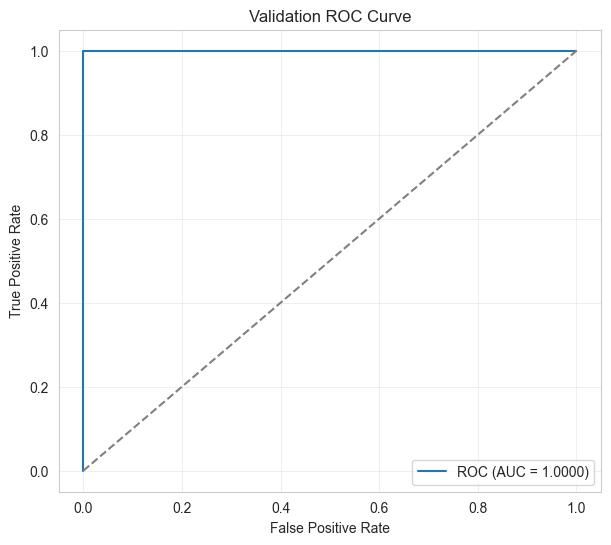

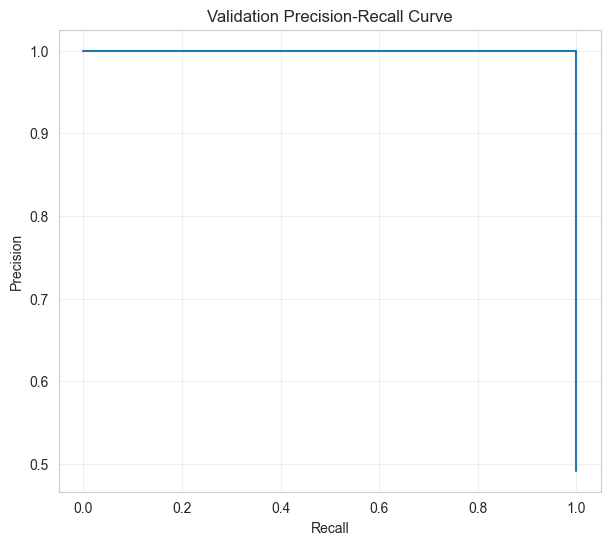

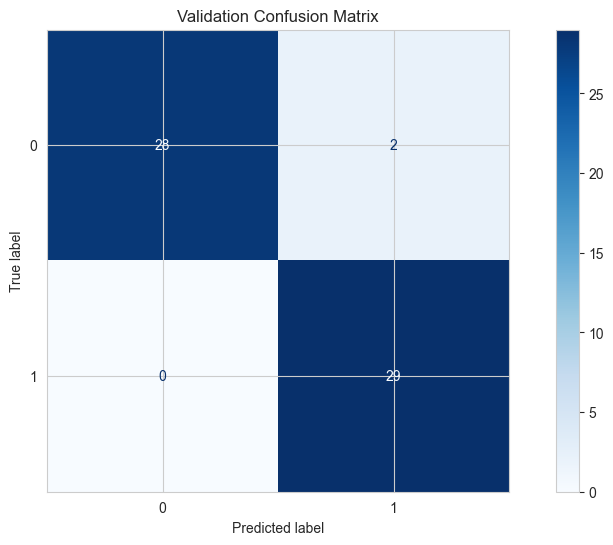

✓ Validation plots saved


In [40]:
# ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(os.path.join(PLOT_DIR, "val_roc_curve.png"), dpi=150, bbox_inches='tight')
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(labels, probs)
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, label="PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Validation Precision-Recall Curve")
plt.grid(alpha=0.3)
plt.savefig(os.path.join(PLOT_DIR, "val_pr_curve.png"), dpi=150, bbox_inches='tight')
plt.show()

# Confusion matrix (threshold 0.5)
preds_bin = (probs >= 0.5).astype(int)
cm = confusion_matrix(labels, preds_bin)
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.savefig(os.path.join(PLOT_DIR, "val_confusion_matrix.png"), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Validation plots saved")


## Training History Visualization


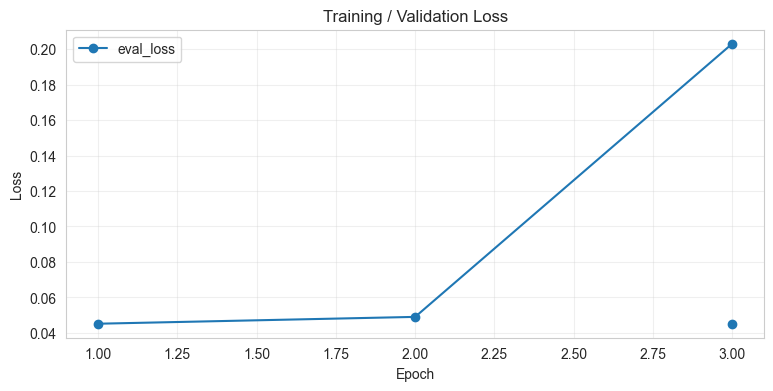

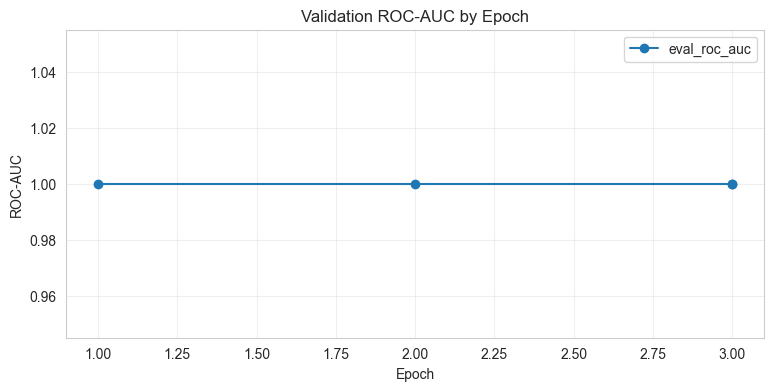

✓ Training history plots saved


In [41]:
# Training log visualization
log_history = trainer.state.log_history
if log_history:
    df_logs = pd.DataFrame(log_history)
    df_logs = df_logs[df_logs["epoch"].notna()]
    
    if not df_logs.empty:
        # Loss curves
        plt.figure(figsize=(9, 4))
        if "loss" in df_logs.columns:
            plt.plot(df_logs["epoch"], df_logs["loss"], marker="o", label="train_loss")
        if "eval_loss" in df_logs.columns:
            plt.plot(df_logs["epoch"], df_logs["eval_loss"], marker="o", label="eval_loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training / Validation Loss")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.savefig(os.path.join(PLOT_DIR, "losses.png"), dpi=150, bbox_inches='tight')
        plt.show()
        
        # ROC-AUC by epoch
        if "eval_roc_auc" in df_logs.columns:
            plt.figure(figsize=(9, 4))
            plt.plot(df_logs["epoch"], df_logs["eval_roc_auc"], marker="o", label="eval_roc_auc")
            plt.xlabel("Epoch")
            plt.ylabel("ROC-AUC")
            plt.title("Validation ROC-AUC by Epoch")
            plt.legend()
            plt.grid(alpha=0.3)
            plt.savefig(os.path.join(PLOT_DIR, "val_roc_by_epoch.png"), dpi=150, bbox_inches='tight')
            plt.show()

print("✓ Training history plots saved")


## Save Validation Predictions


In [42]:
# Save validation predictions
val_out = val_df.copy()
val_out["pred_prob_ai"] = probs
val_out["pred_label"] = preds_bin
val_out.to_csv("val_predictions_with_probs.csv", index=False)
print("✓ Saved val_predictions_with_probs.csv")
print(f"\nValidation predictions summary:")
print(val_out[["label", "pred_prob_ai", "pred_label"]].describe())


✓ Saved val_predictions_with_probs.csv

Validation predictions summary:
           label  pred_prob_ai  pred_label
count  59.000000     59.000000   59.000000
mean    0.491525      0.516187    0.525424
std     0.504219      0.488747    0.503640
min     0.000000      0.000848    0.000000
25%     0.000000      0.002744    0.000000
50%     0.000000      0.757421    1.000000
75%     1.000000      0.998505    1.000000
max     1.000000      0.998805    1.000000


## Predict on Test Set


In [ ]:
# Predict on test set
print(f"Tokenized test set size: {len(test_ds)}")
print("Predicting on test set...")

# Note: If OPTIMAL_THRESHOLD was computed above, you can use it for binary predictions
# For submission, we use probabilities (not binary labels) as required by the competition format
# If you need binary predictions elsewhere, use: (test_probs >= OPTIMAL_THRESHOLD).astype(int)

test_preds = trainer.predict(test_ds)
test_logits = test_preds.predictions
test_probs = torch.softmax(torch.from_numpy(test_logits), dim=1).numpy()[:, 1]

# Retrieve original ids from test_df
ids = test_df["id"].tolist()
if len(ids) != len(test_probs):
    # Fallback: use orig_id from test_ds if available
    if "orig_id" in test_ds.column_names:
        ids = test_ds["orig_id"]
    else:
        ids = list(range(len(test_probs)))

# Create submission (using probabilities, not binary predictions)
submission_df = pd.DataFrame({"id": ids, "is_cheating": test_probs})
submission_csv = "submission_transfer_learning.csv"
submission_df.to_csv(submission_csv, index=False)

print(f"✓ Saved submission to {submission_csv} ({len(submission_df)} rows)")
print(f"\nSubmission statistics:")
print(submission_df["is_cheating"].describe())

# If optimal threshold was computed, show how many would be classified as AI-generated
if 'OPTIMAL_THRESHOLD' in globals():
    binary_preds_optimal = (test_probs >= OPTIMAL_THRESHOLD).astype(int)
    print(f"\nNote: Using optimal threshold ({OPTIMAL_THRESHOLD:.3f}) for binary classification:")
    print(f"  Predicted as AI-generated (label=1): {binary_preds_optimal.sum()} samples")
    print(f"  Predicted as Human-written (label=0): {(binary_preds_optimal == 0).sum()} samples")


Tokenized test set size: 264
Predicting on test set...
✓ Saved submission to submission_transfer_learning.csv (264 rows)

Submission statistics:
count    264.000000
mean       0.579167
std        0.480589
min        0.000746
25%        0.002715
50%        0.997072
75%        0.998588
max        0.998846
Name: is_cheating, dtype: float64


## Test Set Probability Distribution


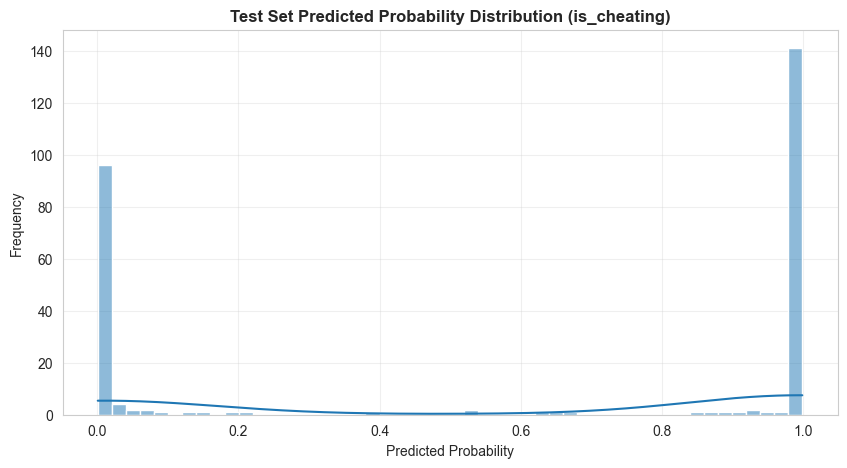


ALL DONE!
✓ Model trained and evaluated
✓ Plots saved in ./plots
✓ Submission saved: submission_transfer_learning.csv
✓ Model saved: ./finetuned_roberta_ann_topic_answer

Final Validation ROC-AUC: 1.0000


In [44]:
# Plot test distribution
plt.figure(figsize=(10, 5))
sns.histplot(test_probs, bins=50, kde=True)
plt.title("Test Set Predicted Probability Distribution (is_cheating)", fontweight='bold')
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.savefig(os.path.join(PLOT_DIR, "test_prob_dist.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print("ALL DONE!")
print(f"{'='*60}")
print(f"✓ Model trained and evaluated")
print(f"✓ Plots saved in {PLOT_DIR}")
print(f"✓ Submission saved: {submission_csv}")
print(f"✓ Model saved: {OUTPUT_DIR}")
print(f"\nFinal Validation ROC-AUC: {roc_auc_val:.4f}")


## Benchmark on HC3

Evaluate your trained model on standard benchmarks to compare with other methods.


In [ ]:
# Benchmark the trained model on HC3 and AdvGLUE
try:
    from data_processing import benchmark_model
    
    print("\n" + "="*60)
    print("BENCHMARKING MODEL ON STANDARD DATASETS")
    print("="*60)
    print("\nThis will evaluate your model on:")
    print("  - HC3: Human ChatGPT Comparison Corpus")
    print("  - AdvGLUE: Adversarial GLUE benchmark")
    print("\nNote: First run will download datasets (may take a few minutes)")
    
    # Run benchmarks
    benchmark_results = benchmark_model(
        model=model,
        tokenizer=tokenizer,
        benchmarks=["hc3", "advglue"],
        splits={"hc3": "test", "advglue": "test"},
        combine_topic_answer=True,  # Match your training format
        batch_size=16
    )
    
    print("\n" + "="*60)
    print("BENCHMARK RESULTS")
    print("="*60)
    print(benchmark_results.to_string(index=False))
    
    # Save results
    benchmark_results.to_csv("benchmark_results.csv", index=False)
    print("\n✓ Saved benchmark results to benchmark_results.csv")
    
    # Visualize results
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(benchmark_results))
    width = 0.15
    
    metrics = ['roc_auc', 'accuracy', 'f1']
    for i, metric in enumerate(metrics):
        ax.bar(x + i*width, benchmark_results[metric], width, label=metric.upper())
    
    ax.set_xlabel('Benchmark', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Model Performance on Benchmarks', fontweight='bold', fontsize=14)
    ax.set_xticks(x + width)
    ax.set_xticklabels(benchmark_results['benchmark'])
    ax.legend()
    ax.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "benchmark_results.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
except ImportError as e:
    print(f"Benchmarking not available: {e}")
    print("Install datasets library: pip install datasets")
except Exception as e:
    print(f"Error during benchmarking: {e}")
    import traceback
    traceback.print_exc()


BENCHMARKING MODEL ON STANDARD DATASETS

This will evaluate your model on:
  - HC3: Human ChatGPT Comparison Corpus
  - AdvGLUE: Adversarial GLUE benchmark

Note: First run will download datasets (may take a few minutes)

Evaluating on HC3
Loading HC3 dataset (split=test, domain=None)...
Split 'test' not available. Using 'train' instead.
✓ Loaded 85431 samples from HC3
  Human samples (label=0): 58546
  AI samples (label=1): 26885
